### Βήμα 3: Classification δεδομένων

#### Βιβλιοθήκες

In [75]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import f1_score
from xgboost import XGBClassifier

#### Φόρτωση δεδομένων

In [76]:
bank_data = pd.read_csv('../data_preprocessing/clean_data.csv')
# Get rid of unwanted extra column
bank_data.drop('Unnamed: 0', axis=1, inplace=True)

### 1ος Ταξινομητής: Bayesian

#### Encoding κατηγορικών χαρακτηριστικών

In [77]:
le = LabelEncoder()
categorical_columns = ['job','marital','education','default','housing','loan','month','y']

for column in categorical_columns:
    bank_data[column] = le.fit_transform(bank_data[column])

#### Διαχωρισμός εξαρτημένων(y) και ανεξάρτηων μεταβλητών

In [78]:
X = bank_data.iloc[:,:-1].values
y = bank_data.iloc[:,-1].values

#### Split

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=True)

#### Κανονικοποίηση

In [80]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Εκπαίδευση του Bayesian ταξινομητή

In [81]:
classifier = GaussianNB()
classifier.fit(X_train, y_train)

GaussianNB()

In [82]:
y_prediction = classifier.predict(X_test)
print(np.concatenate((y_prediction.reshape(len(y_prediction), 1), y_test.reshape(len(y_test), 1)), 1))

[[0 0]
 [0 0]
 [0 0]
 ...
 [0 0]
 [0 0]
 [0 0]]


### Αξιολόγηση ταξινομητή

#### Accuracy Score

In [83]:
accuracy_score(y_test, y_prediction)

0.8856935967725251

#### Classification Report

In [84]:
print(f'Classification Report: \n{classification_report(y_test, y_prediction)}')

Classification Report: 
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      8843
           1       0.33      0.33      0.33       824

    accuracy                           0.89      9667
   macro avg       0.63      0.64      0.64      9667
weighted avg       0.89      0.89      0.89      9667



#### Confusion Matrix

<Axes: >

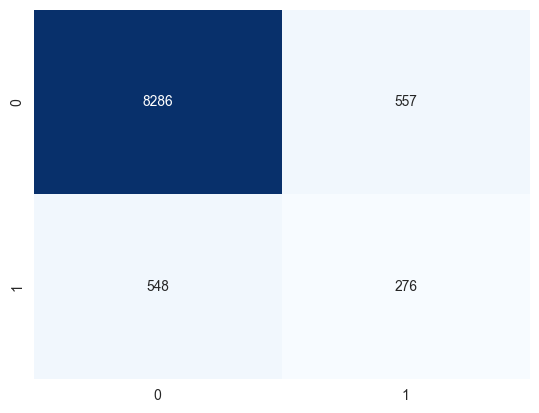

In [85]:
cf_matrix = confusion_matrix(y_test, y_prediction)
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)

#### AUC/ROC curve

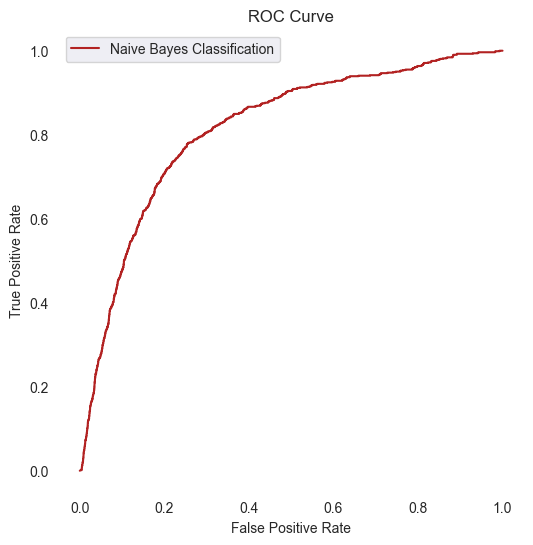

In [86]:
# Plot AUC/ROC curve
y_pred_proba = classifier.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test,  y_pred_proba)

fig, ax = plt.subplots(figsize=(6,6))
ax.plot(fpr, tpr, label='Naive Bayes Classification', color = 'firebrick')
ax.set_title('ROC Curve')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.box(False)
ax.legend();

### 2ος Ταξινομητής: XGBoost

In [87]:
xgb_bank_data = pd.read_csv('../data_preprocessing/clean_data.csv')
# xgb_bank_data.columns
xgb_bank_data.drop('Unnamed: 0', axis=1, inplace=True)

In [88]:
text_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'month', 'y']
oe = OrdinalEncoder()

for column in text_cols:
    xgb_bank_data[column] = oe.fit_transform(xgb_bank_data[[column]])

In [89]:
X_xgb= bank_data.iloc[:,:-1].values
y_xgb = bank_data.iloc[:,-1].values
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_xgb, y_xgb, test_size=0.2, random_state=42)


In [91]:
xgboost_classifier = XGBClassifier(n_estimators=25,n_jobs=-1)
xgboost_classifier.fit(X_train_xgb, y_train_xgb, verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=25, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

In [92]:
xgboost_classifier.score(X_test_xgb, y_test_xgb)

0.9251357641582623

Text(50.722222222222214, 0.5, 'True Label')

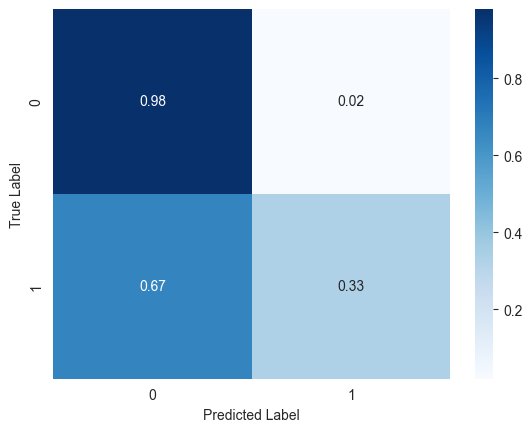

In [94]:
ax = sns.heatmap (
    confusion_matrix(y_test_xgb, xgboost_classifier.predict(X_test_xgb), normalize='true').round(2),
    annot=True, cmap='Blues'
)

ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

In [95]:
print(classification_report(y_test_xgb, xgboost_classifier.predict(X_test_xgb)))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      7070
           1       0.62      0.33      0.43       664

    accuracy                           0.93      7734
   macro avg       0.78      0.66      0.70      7734
weighted avg       0.91      0.93      0.91      7734



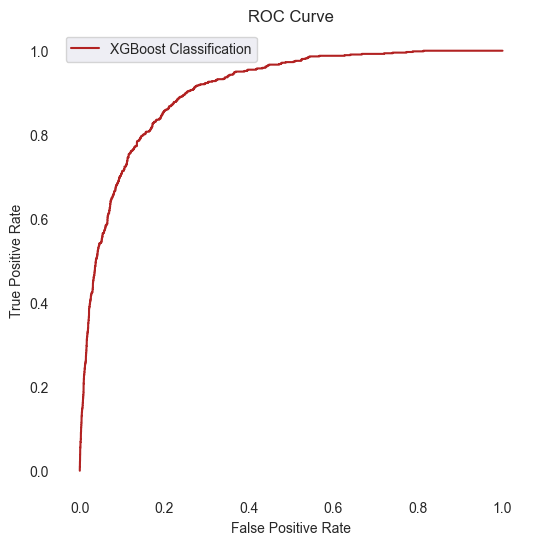

In [96]:
# Plot AUC/ROC curve
y_pred_proba_xgb = xgboost_classifier.predict_proba(X_test_xgb)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test_xgb,  y_pred_proba_xgb)

fig, ax = plt.subplots(figsize=(6,6))
ax.plot(fpr, tpr, label='XGBoost Classification', color = 'firebrick')
ax.set_title('ROC Curve')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.box(False)
ax.legend();